#### Import Packages

In [76]:
import numpy as np
import gstools as gs
import pandas as pd
import matplotlib.pyplot as plt

#### Read Primary (observed but still predicted values)

In [77]:
with open("Data/Moisture_Content_All_Soils_Result (3).txt", 'r') as file:
    lines = file.readlines()

#### Clean Nan values

In [78]:
# Parse the data and replace NaN values with 0
x, y, z = [], [], []

for line in lines:
    values = line.split()
    x.append(float(values[0]))
    y.append(float(values[1]))
    z_value = 0 if values[2] == "NaN" else float(values[2])
    z.append(z_value)

# Convert lists to numpy arrays for easier manipulation
x = np.array(x)
y = np.array(y)
z = np.array(z)

#### Read Secondary (auxiliary) (assumed clean from nans etc)

In [79]:
# Read the secondary data file and inspect the first few lines
with open("Data/Secondary Data.txt", 'r') as file:
    lines_secondary = file.readlines()

# Parse the data for secondary dataset
x_secondary, y_secondary, z_secondary = [], [], []

for line in lines_secondary:
    values = line.split()
    x_secondary.append(float(values[0]))
    y_secondary.append(float(values[1]))
    z_secondary.append(float(values[2]))

# Convert lists to numpy arrays for ease
x_secondary = np.array(x_secondary)
y_secondary = np.array(y_secondary)
z_secondary = np.array(z_secondary)

In [80]:
# Checking the first few values of the secondary data
print(x_secondary[:10], y_secondary[:10], z_secondary[:10])

[9. 9. 9. 9. 9. 9. 5. 5. 5. 5.] [-0.5  -1.   -1.5  -2.   -2.5  -3.   -0.45 -0.75 -1.2  -1.6 ] [32.2  28.78 27.06 29.85 28.16 28.87 31.4  33.4  39.2  47.1 ]


#### Define Grid variables

In [81]:
# Create a grid that is twice as precise as the primary data points
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
# Determine the step size based on the unique values in the x and y arrays
x_step = np.diff(np.unique(x)).min() / 2
y_step = np.diff(np.unique(y)).min() / 2

#### Define Cokriging Function 

In [82]:
def cokriging_optimized(primary_data, secondary_data, theta1, theta2):
    N = len(primary_data)
    M = len(secondary_data)
    
    # Calculate distance matrices
    dist_primary = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - primary_data[:, :2], axis=2)
    dist_secondary = np.linalg.norm(secondary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    dist_cross = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    
    # Calculate correlation matrices
    C11 = exponential_correlation(dist_primary, theta1)
    C22 = exponential_correlation(dist_secondary, theta2)
    C12 = exponential_correlation(dist_cross, theta1)
    
    # Log-transform the secondary data
    z_secondary_log = np.log(secondary_data[:, 2])
    
    # Cokriging system
    C = np.block([
        [C11, C12],
        [C12.T, C22]
    ])
    z = np.concatenate([primary_data[:, 2], z_secondary_log])
    
    # Solve for weights
    weights = np.linalg.solve(C, z)
    
    # Cokriging estimate
    z_estimated = np.dot(C11, weights[:N]) + np.dot(C12, weights[N:])
    
    return z_estimated

#### Deifne variogram distribution function (assumption [has to be] made here)

In [83]:
def exponential_correlation(h, theta):
    return np.exp(-np.abs(h) / theta)

#### call Cokriging

In [84]:
# Preparing data in the required format: [x, y, z]
primary_formatted = np.column_stack((x, y, z))
secondary_formatted = np.column_stack((x_secondary, y_secondary, z_secondary))

# Using the provided theta values for this test
theta1_test = 1.5
theta2_test = 1.0

# Predict using the optimized cokriging function
z_estimated_optimized = cokriging_optimized(primary_formatted, secondary_formatted, theta1_test, theta2_test)

#### test

In [85]:
# Predict using the optimized cokriging function over the primary data grid
z_pred_optimized_primary = cokriging_optimized(primary_formatted, secondary_formatted, theta1_test, theta2_test)

# Create a grid for visualization plots 
x_grid, y_grid = np.meshgrid(np.unique(x), np.unique(y))

### Interpolation with bivariate spline (linear)
High computational cost to call cokriging on grid with greater precision than the grid given by Primary Data. Hence, Cokriging should take place on the same or smaller Primary data points and then interpolated on a larger range.

In [86]:
from scipy.interpolate import RectBivariateSpline

In [87]:
# Create a dense grid for the interpolated values
x_dense = np.linspace(x.min(), x.max(), 500)
y_dense = np.linspace(y.min(), y.max(), 500)
x_dense_grid, y_dense_grid = np.meshgrid(x_dense, y_dense)

### Interpolated Cokriging Predictions 

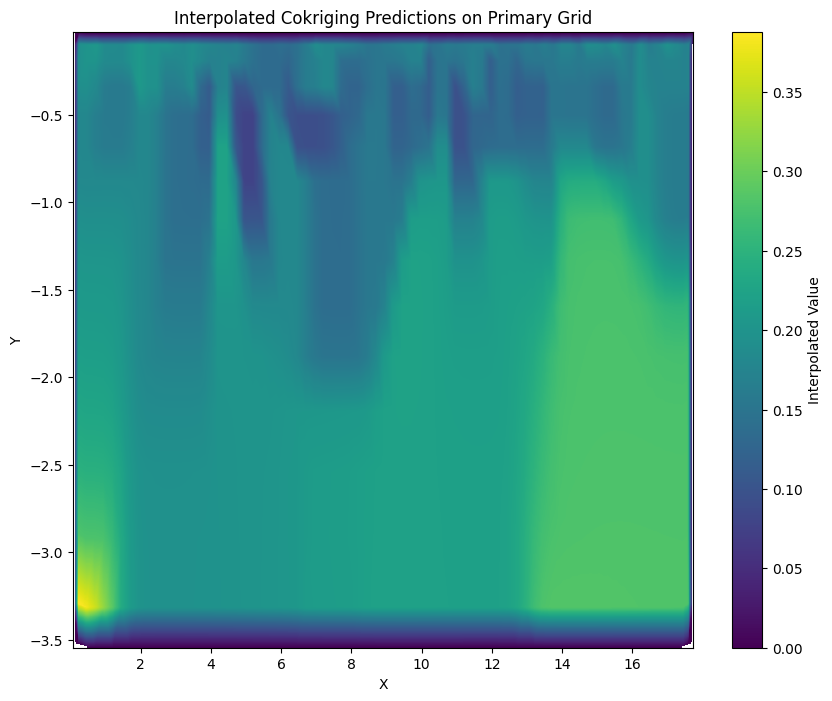

In [88]:
from scipy.interpolate import griddata

# Interpolate using griddata
z_dense_griddata = griddata((x, y), z_pred_optimized_primary, (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8))
plt.imshow(z_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Value")
plt.title("Interpolated Cokriging Predictions on Primary Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [89]:
np.where(z_dense_griddata == -0.5)

(array([], dtype=int64), array([], dtype=int64))

#### Comapre

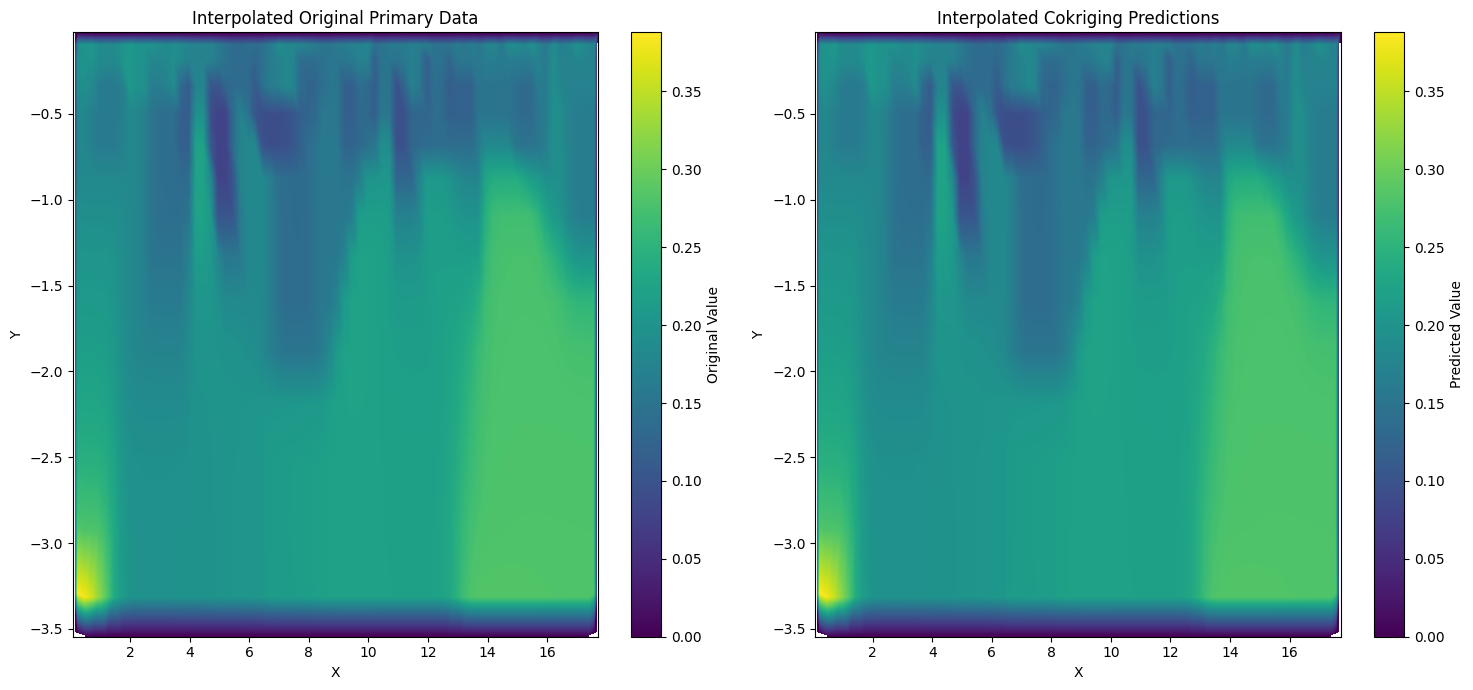

In [90]:
# Interpolate the original primary data using griddata
z_primary_dense = griddata((x, y), z, (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surfaces for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Original primary data interpolation
c1 = ax1.imshow(z_primary_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
fig.colorbar(c1, ax=ax1, label="Original Value")
ax1.set_title("Interpolated Original Primary Data")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# Cokriging predictions interpolation
c2 = ax2.imshow(z_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
fig.colorbar(c2, ax=ax2, label="Predicted Value")
ax2.set_title("Interpolated Cokriging Predictions")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

plt.tight_layout()
plt.show()


### Differences


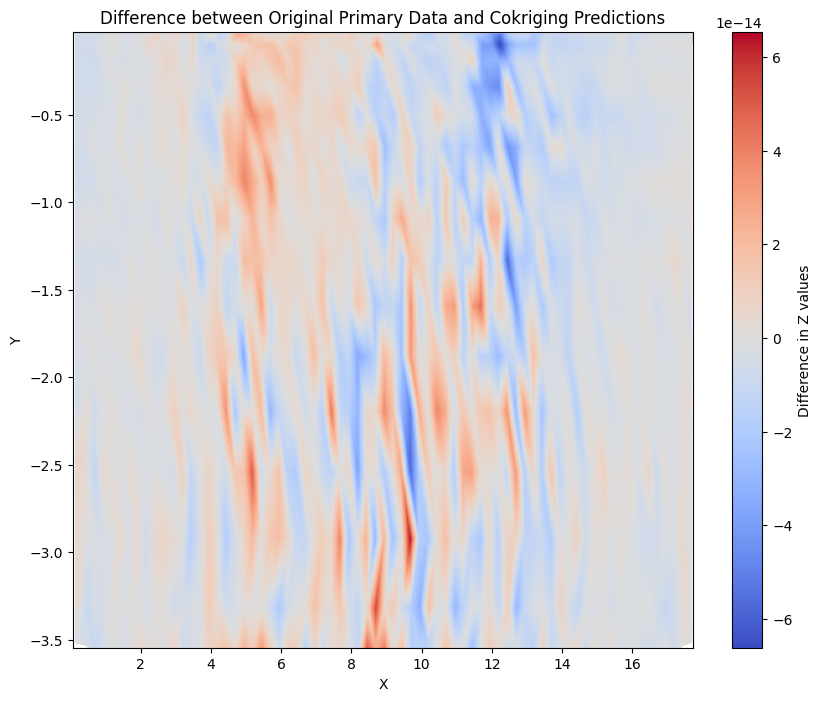

In [91]:
# Compute the difference between the interpolated primary data and cokriging predictions
z_difference = z_dense_griddata - z_primary_dense

# Plot the difference
plt.figure(figsize=(10, 8))
c = plt.imshow(z_difference, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="coolwarm", aspect='auto')
plt.colorbar(c, label="Difference in Z values")
plt.title("Difference between Original Primary Data and Cokriging Predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


so warm => predictions > actual

### Get rid of NAN values from Primary Data

In [92]:
# Correctly identify and remove the first and last sequences of rows with z=0
first_sequence = np.where(z == 0)[0]
first_seq_start = first_sequence[0]
first_seq_end = first_sequence[np.where(np.diff(first_sequence) != 1)[0][0]]

last_sequence = np.where(z == 0)[0]
last_seq_start = last_sequence[np.where(np.diff(last_sequence) != 1)[0][-1] + 1]
last_seq_end = last_sequence[-1]

# Remove these rows from the primary data
x_reduced_corrected = np.delete(x, np.r_[first_seq_start:first_seq_end+1, last_seq_start:last_seq_end+1])
y_reduced_corrected = np.delete(y, np.r_[first_seq_start:first_seq_end+1, last_seq_start:last_seq_end+1])
z_reduced_corrected = np.delete(z, np.r_[first_seq_start:first_seq_end+1, last_seq_start:last_seq_end+1])

# Check the unique z values again
unique_z_reduced_corrected = np.unique(z_reduced_corrected)

### Interpolated Cokriging without the nans in primary data

THere are nans, but this is underflow error and doesnt effect the plot

### Exponetial Model

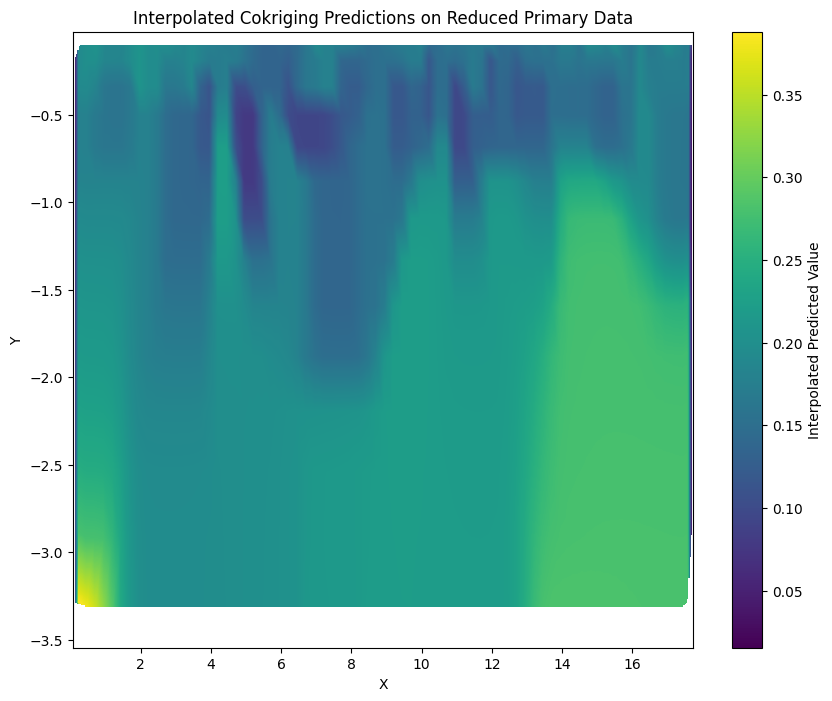

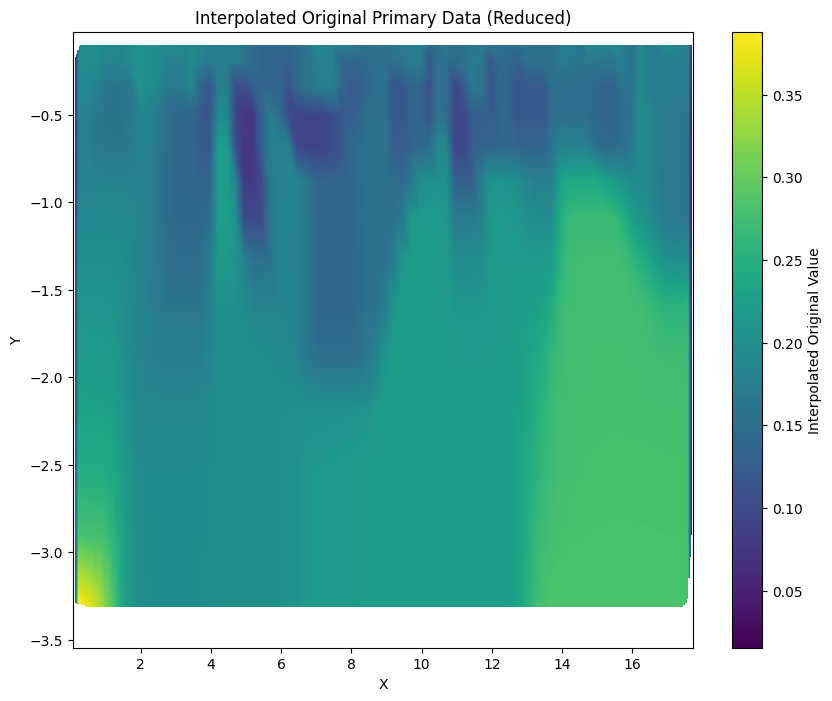

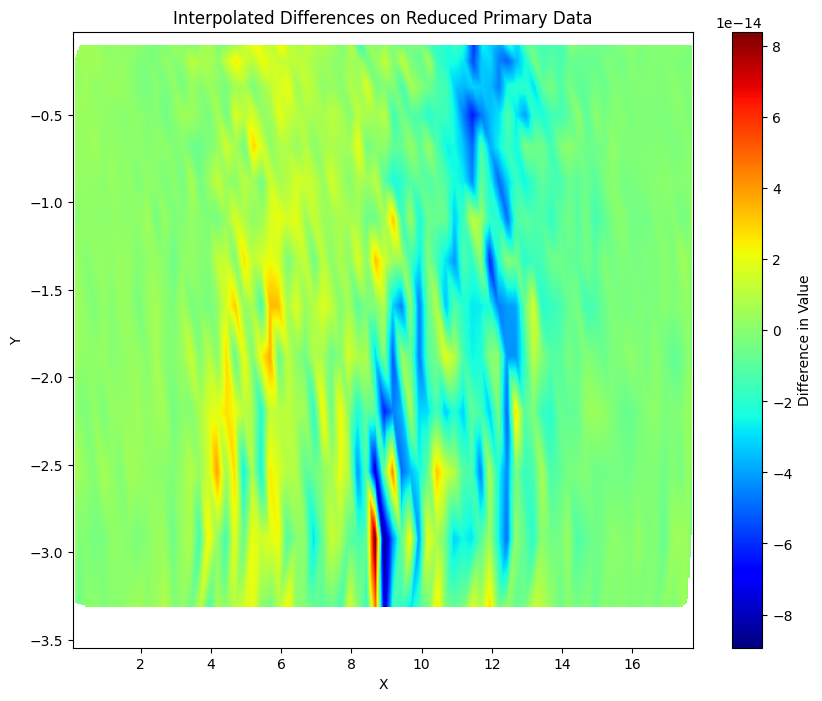

In [93]:
# Prepare the reduced data in the required format: [x, y, z]
primary_reduced_corrected = np.column_stack((x_reduced_corrected, y_reduced_corrected, z_reduced_corrected))

# Predict using the optimized cokriging function over the reduced primary data grid
z_pred_reduced_corrected = cokriging_optimized(primary_reduced_corrected, secondary_formatted, theta1_test, theta2_test)

#########################################################################################################################
# Interpolate the cokriging predictions on the reduced dataset using griddata
z_reduced_dense_griddata = griddata((x_reduced_corrected, y_reduced_corrected), z_pred_reduced_corrected, 
                                    (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8))
plt.imshow(z_reduced_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Predicted Value")
plt.title("Interpolated Cokriging Predictions on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Interpolated Primary without the nans in primary data

# Interpolate the original primary data from the reduced dataset using griddata
z_primary_reduced_dense = griddata((x_reduced_corrected, y_reduced_corrected), z_reduced_corrected, 
                                   (x_dense_grid, y_dense_grid), method='linear')

#########################################################################################################################
# Plot the interpolated surface for the reduced primary data
plt.figure(figsize=(10, 8))
plt.imshow(z_primary_reduced_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Original Value")
plt.title("Interpolated Original Primary Data (Reduced)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

###################################################################################################################

### Differences between the cokriging and the original data without the nans in primary data

# Compute the differences between the interpolated primary data and cokriging predictions on the reduced dataset
z_difference_reduced = z_reduced_dense_griddata - z_primary_reduced_dense

# Plot the interpolated differences using the "jet" colormap
plt.figure(figsize=(10, 8))
plt.imshow(z_difference_reduced, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="jet", aspect='auto')
plt.colorbar(label="Difference in Value")
plt.title("Interpolated Differences on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Gaussian Model
define the same function name so we dont have to change any other code

In [94]:
def gaussian_correlation(h, theta):
    return  np.exp(-h**2 / theta**2)

In [95]:
def cokriging_optimized(primary_data, secondary_data, theta1, theta2):
    N = len(primary_data)
    M = len(secondary_data)
    
    # Calculate distance matrices
    dist_primary = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - primary_data[:, :2], axis=2)
    dist_secondary = np.linalg.norm(secondary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    dist_cross = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    
    # Calculate correlation matrices
    C11 = gaussian_correlation(dist_primary, theta1)
    C22 = gaussian_correlation(dist_secondary, theta2)
    C12 = gaussian_correlation(dist_cross, theta1)
    
    # Log-transform the secondary data
    z_secondary_log = np.log(secondary_data[:, 2])
    
    # Cokriging system
    C = np.block([
        [C11, C12],
        [C12.T, C22]
    ])
    z = np.concatenate([primary_data[:, 2], z_secondary_log])
    
    # Solve for weights
    weights = np.linalg.solve(C, z)
    
    # Cokriging estimate
    z_estimated = np.dot(C11, weights[:N]) + np.dot(C12, weights[N:])
    
    return z_estimated


In [96]:
theta1_test,theta2_test = [0.79,8]

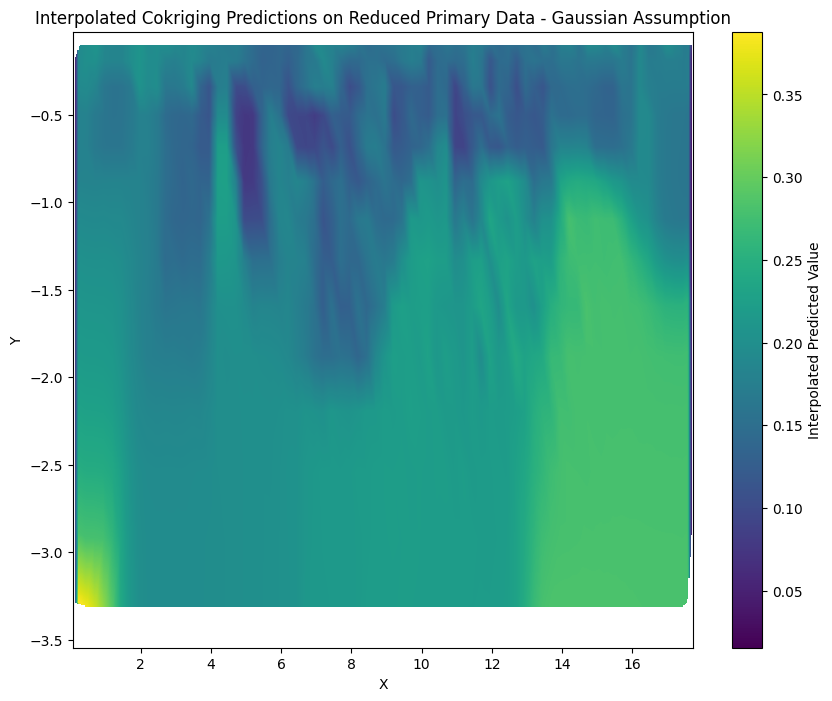

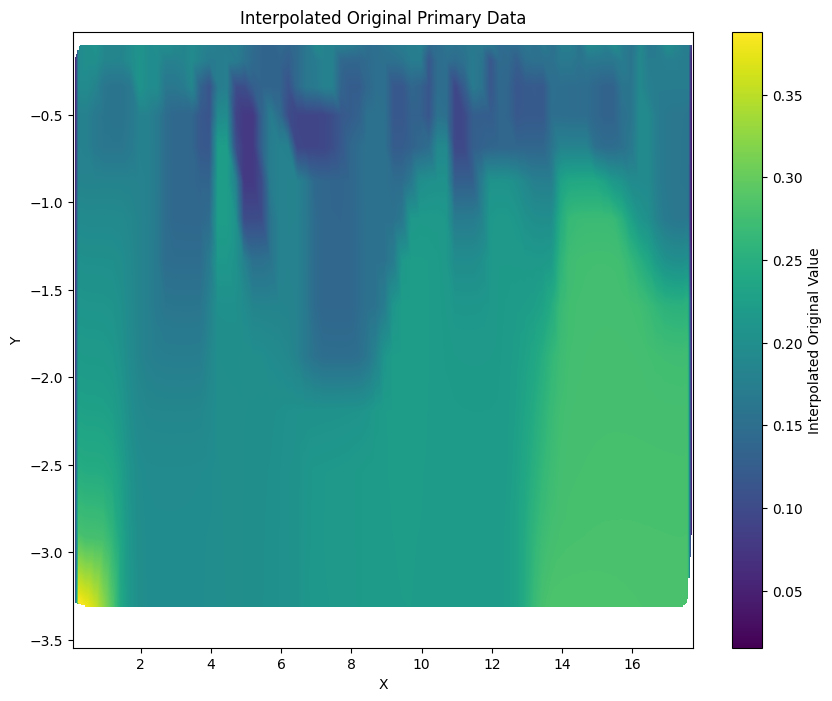

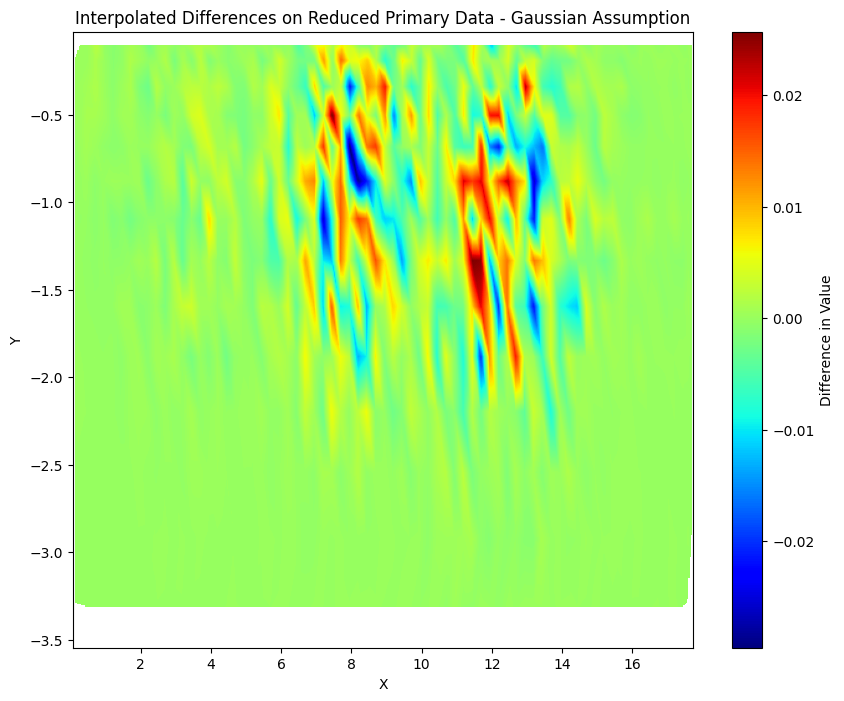

In [97]:
# Prepare the reduced data in the required format: [x, y, z]
primary_reduced_corrected = np.column_stack((x_reduced_corrected, y_reduced_corrected, z_reduced_corrected))

# Predict using the optimized cokriging function over the reduced primary data grid
z_pred_reduced_corrected = cokriging_optimized(primary_reduced_corrected, secondary_formatted, theta1_test, theta2_test)

#########################################################################################################################
# Interpolate the cokriging predictions on the reduced dataset using griddata
z_reduced_dense_griddata = griddata((x_reduced_corrected, y_reduced_corrected), z_pred_reduced_corrected, 
                                    (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8 ))
plt.imshow(z_reduced_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Predicted Value")
plt.title("Interpolated Cokriging Predictions on Reduced Primary Data - Gaussian Assumption")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Interpolated Primary without the nans in primary data

# Interpolate the original primary data from the reduced dataset using griddata
z_primary_reduced_dense = griddata((x_reduced_corrected, y_reduced_corrected), z_reduced_corrected, 
                                   (x_dense_grid, y_dense_grid), method='linear')

#########################################################################################################################
# Plot the interpolated surface for the reduced primary data
plt.figure(figsize=(10, 8))
plt.imshow(z_primary_reduced_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Original Value")
plt.title("Interpolated Original Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

###################################################################################################################

### Differences between the cokriging and the original data without the nans in primary data

# Compute the differences between the interpolated primary data and cokriging predictions on the reduced dataset
z_difference_reduced = z_reduced_dense_griddata - z_primary_reduced_dense

# Plot the interpolated differences using the "jet" colormap
plt.figure(figsize=(10, 8))
plt.imshow(z_difference_reduced, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="jet", aspect='auto')
plt.colorbar(label="Difference in Value")
plt.title("Interpolated Differences on Reduced Primary Data - Gaussian Assumption")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Spherical Model

In [98]:
def spherical_correlation(h, theta):
    # Using the range parameter theta as 'a' for the spherical function
    a = theta
    
    # Calculate correlation for values of h < a
    correlation = (3*h / (2*a) - (h**3 / (2*a**3)))
    
    # Set correlation to 1 for values of h >= a
    correlation[h >= a] = 1
    
    return 1 - correlation

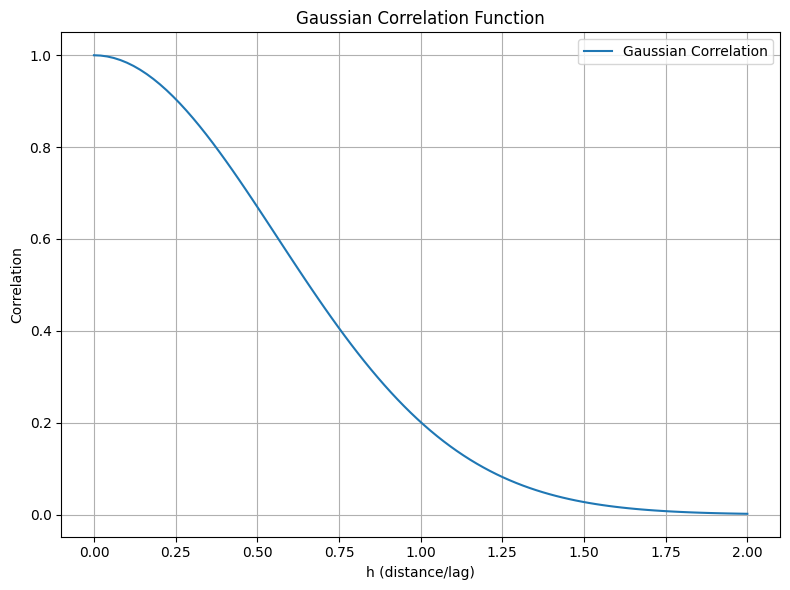

In [99]:
# Test the spherical_correlation function
h_values = np.linspace(0, 2, 100)
correlation_values = gaussian_correlation(h_values, theta1_test)

plt.figure(figsize=(8, 6))
plt.plot(h_values, correlation_values, label='Gaussian Correlation')
plt.xlabel('h (distance/lag)')
plt.ylabel('Correlation')
plt.title('Gaussian Correlation Function')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
def cokriging_optimized(primary_data, secondary_data, theta1, theta2):
    N = len(primary_data)
    M = len(secondary_data)
    
    # Calculate distance matrices
    dist_primary = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - primary_data[:, :2], axis=2)
    dist_secondary = np.linalg.norm(secondary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    dist_cross = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    
    # Calculate correlation matrices
    C11 = spherical_correlation(dist_primary, theta1)
    C22 = spherical_correlation(dist_secondary, theta2)
    C12 = spherical_correlation(dist_cross, theta1)
    
    # Log-transform the secondary data
    z_secondary_log = np.log(secondary_data[:, 2])
    
    # Cokriging system
    C = np.block([
        [C11, C12],
        [C12.T, C22]
    ])
    z = np.concatenate([primary_data[:, 2], z_secondary_log])
    
    # Solve for weights
    weights = np.linalg.solve(C, z)
    
    # Cokriging estimate
    z_estimated = np.dot(C11, weights[:N]) + np.dot(C12, weights[N:])
    
    return z_estimated

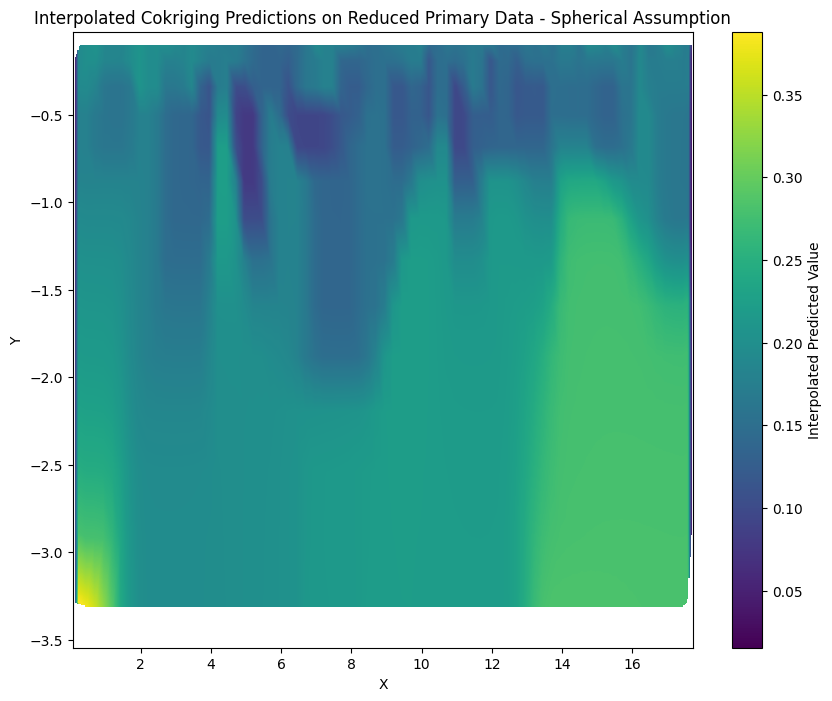

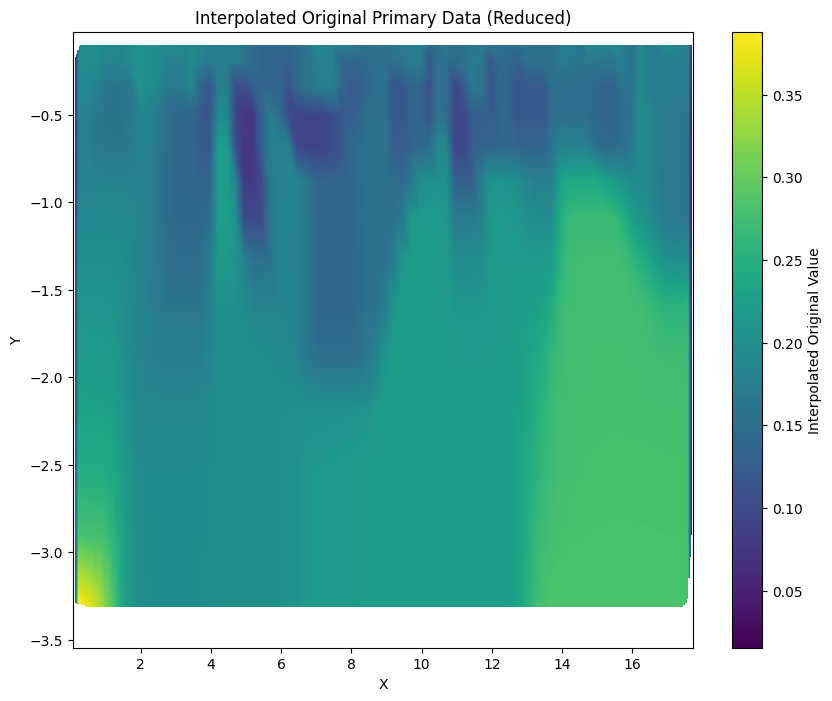

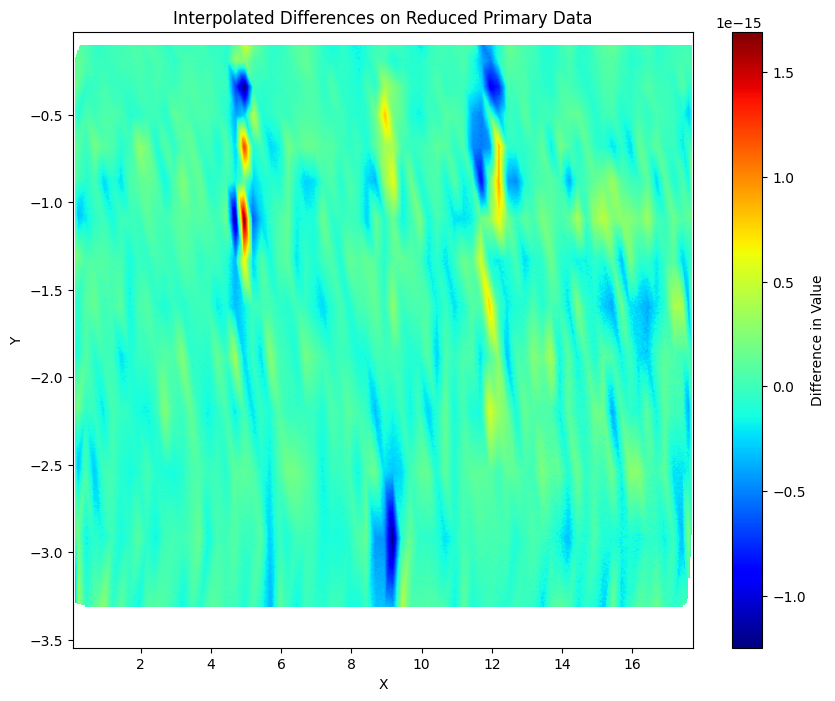

In [101]:
# Prepare the reduced data in the required format: [x, y, z]
primary_reduced_corrected = np.column_stack((x_reduced_corrected, y_reduced_corrected, z_reduced_corrected))

# Predict using the optimized cokriging function over the reduced primary data grid
z_pred_reduced_corrected = cokriging_optimized(primary_reduced_corrected, secondary_formatted, theta1_test, theta2_test)

#########################################################################################################################
# Interpolate the cokriging predictions on the reduced dataset using griddata
z_reduced_dense_griddata = griddata((x_reduced_corrected, y_reduced_corrected), z_pred_reduced_corrected, 
                                    (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8))
plt.imshow(z_reduced_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Predicted Value")
plt.title("Interpolated Cokriging Predictions on Reduced Primary Data - Spherical Assumption")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Interpolated Primary without the nans in primary data

# Interpolate the original primary data from the reduced dataset using griddata
z_primary_reduced_dense = griddata((x_reduced_corrected, y_reduced_corrected), z_reduced_corrected, 
                                   (x_dense_grid, y_dense_grid), method='linear')

#########################################################################################################################
# Plot the interpolated surface for the reduced primary data
plt.figure(figsize=(10, 8))
plt.imshow(z_primary_reduced_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Original Value")
plt.title("Interpolated Original Primary Data (Reduced)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

###################################################################################################################

### Differences between the cokriging and the original data without the nans in primary data

# Compute the differences between the interpolated primary data and cokriging predictions on the reduced dataset
z_difference_reduced = z_reduced_dense_griddata - z_primary_reduced_dense

# Plot the interpolated differences using the "jet" colormap
plt.figure(figsize=(10, 8))
plt.imshow(z_difference_reduced, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="jet", aspect='auto')
plt.colorbar(label="Difference in Value")
plt.title("Interpolated Differences on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


#### Spherical Model $\theta$ = 2

In [102]:
def spherical_correlation(h, theta):
    # Using the range parameter theta as 'a' for the spherical function
    a = theta
    
    # Calculate correlation for values of h < a
    correlation = (3*h / (2*a) - (h**3 / (2*a**3)))
    
    # Set correlation to 1 for values of h >= a
    correlation[h >= a] = 1
    
    return 1 - correlation

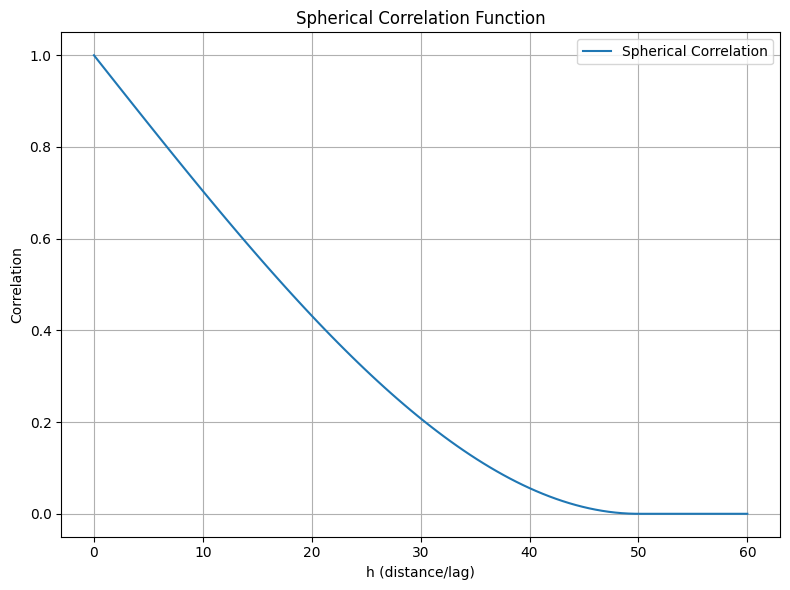

In [103]:
# Test the spherical_correlation function
h_values = np.linspace(0, 60, 100)
correlation_values = spherical_correlation(h_values, 50)

plt.figure(figsize=(8, 6))
plt.plot(h_values, correlation_values, label='Spherical Correlation')
plt.xlabel('h (distance/lag)')
plt.ylabel('Correlation')
plt.title('Spherical Correlation Function')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

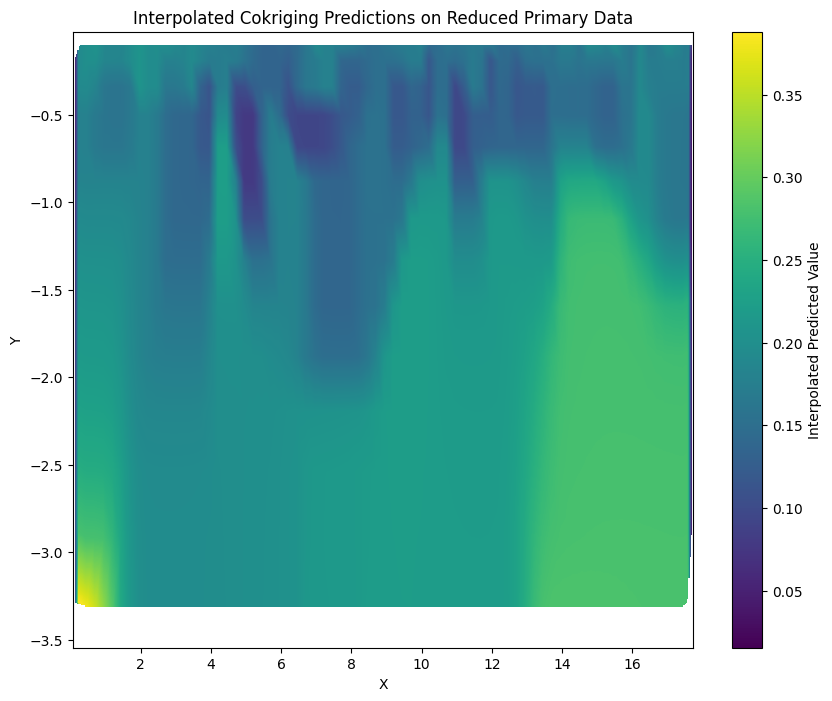

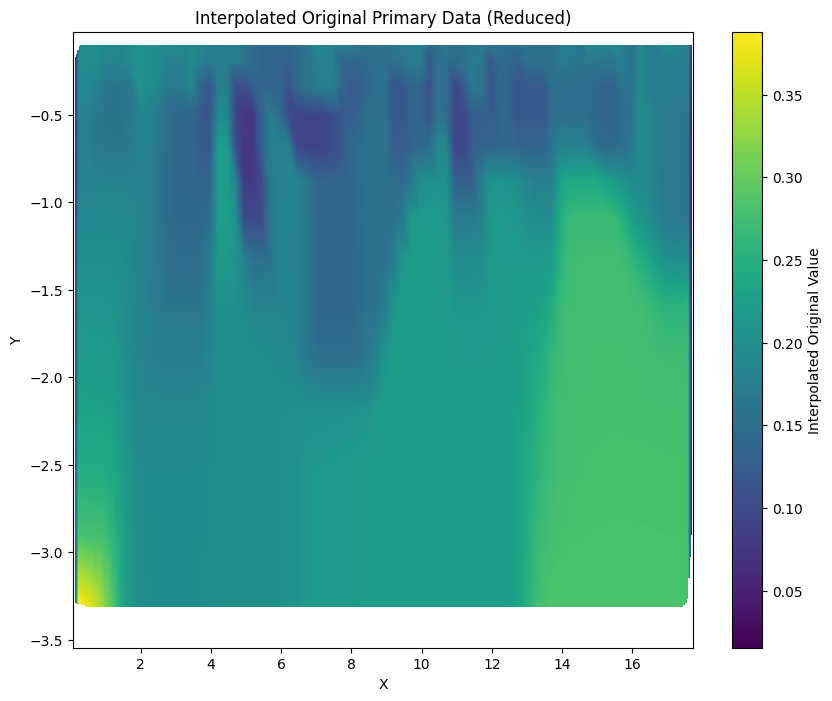

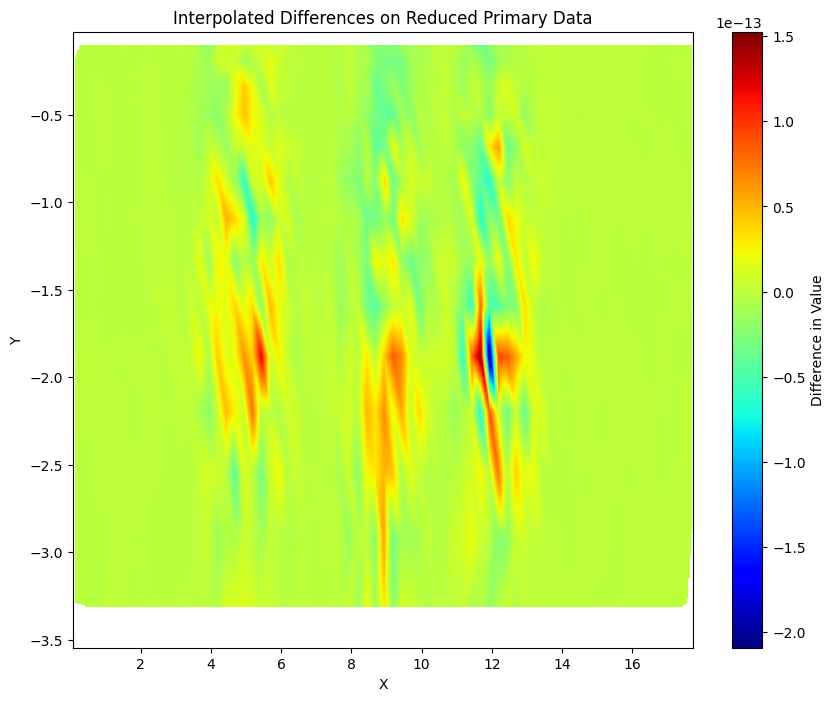

In [104]:
# Prepare the reduced data in the required format: [x, y, z]
primary_reduced_corrected = np.column_stack((x_reduced_corrected, y_reduced_corrected, z_reduced_corrected))

# Predict using the optimized cokriging function over the reduced primary data grid
z_pred_reduced_corrected = cokriging_optimized(primary_reduced_corrected, secondary_formatted, 2, 2) # changed here

#########################################################################################################################
# Interpolate the cokriging predictions on the reduced dataset using griddata
z_reduced_dense_griddata = griddata((x_reduced_corrected, y_reduced_corrected), z_pred_reduced_corrected, 
                                    (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8))
plt.imshow(z_reduced_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Predicted Value")
plt.title("Interpolated Cokriging Predictions on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### Interpolated Primary without the nans in primary data

# Interpolate the original primary data from the reduced dataset using griddata
z_primary_reduced_dense = griddata((x_reduced_corrected, y_reduced_corrected), z_reduced_corrected, 
                                   (x_dense_grid, y_dense_grid), method='linear')

#########################################################################################################################
# Plot the interpolated surface for the reduced primary data
plt.figure(figsize=(10, 8))
plt.imshow(z_primary_reduced_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Original Value")
plt.title("Interpolated Original Primary Data (Reduced)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

###################################################################################################################

### Differences between the cokriging and the original data without the nans in primary data

# Compute the differences between the interpolated primary data and cokriging predictions on the reduced dataset
z_difference_reduced = z_reduced_dense_griddata - z_primary_reduced_dense

# Plot the interpolated differences using the "jet" colormap
plt.figure(figsize=(10, 8))
plt.imshow(z_difference_reduced, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="jet", aspect='auto')
plt.colorbar(label="Difference in Value")
plt.title("Interpolated Differences on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


#### Log Normal

In [105]:
def log_normal_correlation(h, theta):
    # Ensure h is a numpy array
    h = np.array(h)
    
    # Parameters for the log-normal function
    mu = 0
    sigma = theta
    
    # Case where h=0 separately to avoid division by zero
    correlation = np.zeros_like(h)
    nonzero_h = h != 0
    correlation[nonzero_h] = (1 / (h[nonzero_h] * sigma * np.sqrt(2 * np.pi))) * \
                             np.exp(-((np.log(h[nonzero_h]) - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize the function such that its value at h=0 is 1
    normalization_factor = (1 / (sigma * np.sqrt(2 * np.pi)))  # Value of the log-normal function at h=0
    correlation /= normalization_factor
    correlation[~nonzero_h] = 1  # Set the correlation value to 1 for h=0
    
    return correlation


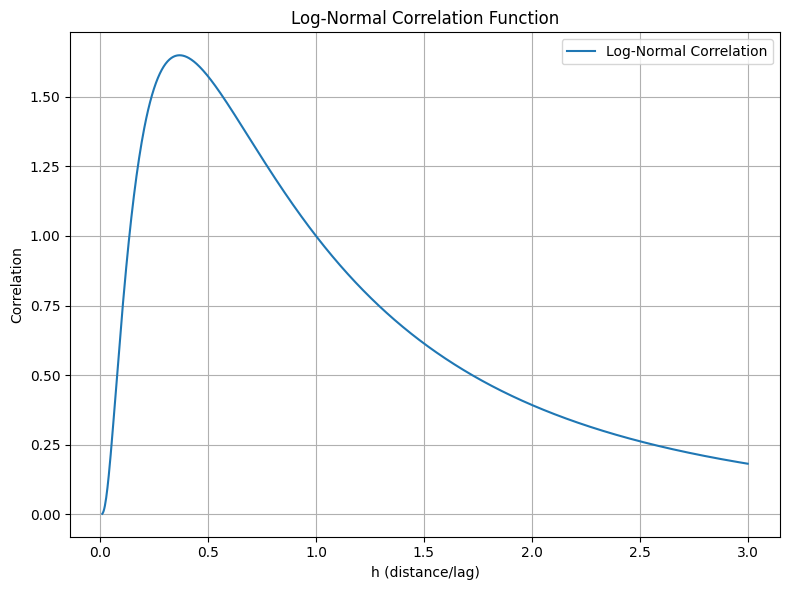

In [106]:
# Test the log_normal_correlation function
h_values = np.linspace(0.01, 3, 1000)
correlation_values = log_normal_correlation(h_values, 1)

plt.figure(figsize=(8, 6))
plt.plot(h_values, correlation_values, label='Log-Normal Correlation')
plt.xlabel('h (distance/lag)')
plt.ylabel('Correlation')
plt.title('Log-Normal Correlation Function')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
def cokriging_optimized(primary_data, secondary_data, theta1, theta2):
    N = len(primary_data)
    M = len(secondary_data)
    
    # Calculate distance matrices
    dist_primary = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - primary_data[:, :2], axis=2)
    dist_secondary = np.linalg.norm(secondary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    dist_cross = np.linalg.norm(primary_data[:, :2][:, np.newaxis, :] - secondary_data[:, :2], axis=2)
    
    #print(dist_primary,dist_cross,dist_secondary)
    
    # Calculate correlation matrices - dists cant be 0 as div by 0 for log norm model
    C11 = log_normal_correlation(dist_primary, theta1)
    C22 = log_normal_correlation(dist_secondary, theta2)
    C12 = log_normal_correlation(dist_cross, theta1)
    
    # Log-transform the secondary data
    z_secondary_log = np.log(secondary_data[:, 2])
    
    # Cokriging system
    C = np.block([
        [C11, C12],
        [C12.T, C22]
    ])
    z = np.concatenate([primary_data[:, 2], z_secondary_log])
    
    # Solve for weights
    weights = np.linalg.solve(C, z)
    
    # Cokriging estimate
    z_estimated = np.dot(C11, weights[:N]) + np.dot(C12, weights[N:])
    
    return z_estimated

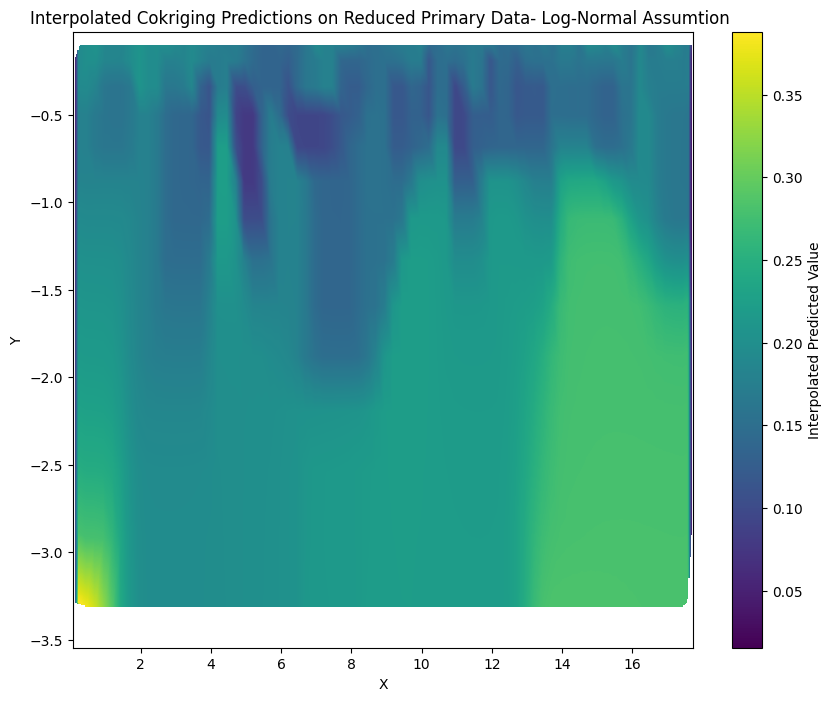

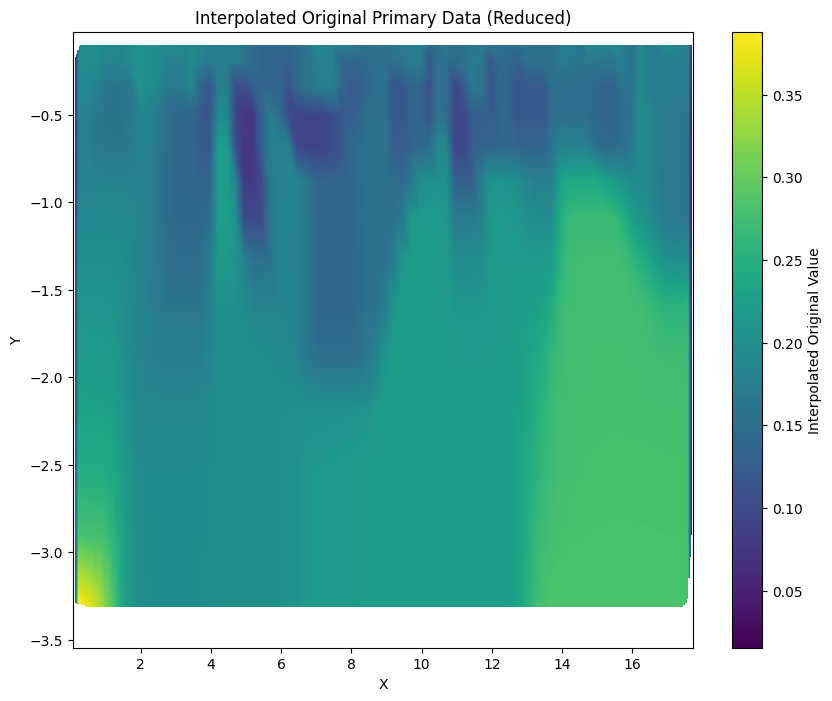

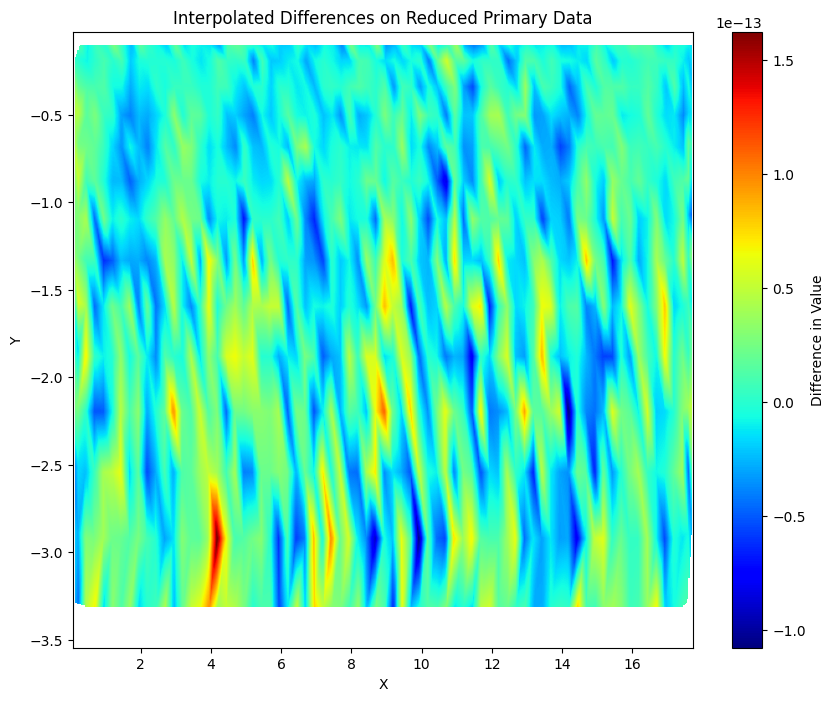

In [108]:
# Prepare the reduced data in the required format: [x, y, z]
primary_reduced_corrected = np.column_stack((x_reduced_corrected, y_reduced_corrected, z_reduced_corrected))
#########################################################################################################################
# Predict COKRIGING

# Predict using the optimized cokriging function over the reduced primary data grid
z_pred_reduced_corrected = cokriging_optimized(primary_reduced_corrected, secondary_formatted, theta1_test, theta2_test)

#########################################################################################################################
# Interpolation 

# Interpolate the cokriging predictions on the reduced dataset using griddata
z_reduced_dense_griddata = griddata((x_reduced_corrected, y_reduced_corrected), z_pred_reduced_corrected, 
                                    (x_dense_grid, y_dense_grid), method='linear')

# Plot the interpolated surface
plt.figure(figsize=(10, 8))
plt.imshow(z_reduced_dense_griddata, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Predicted Value")
plt.title("Interpolated Cokriging Predictions on Reduced Primary Data- Log-Normal Assumtion ")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#########################################################################################################################
### Interpolated Primary without the nans in PRIMARY DATA

# Interpolate the original primary data from the reduced dataset using griddata
z_primary_reduced_dense = griddata((x_reduced_corrected, y_reduced_corrected), z_reduced_corrected, 
                                   (x_dense_grid, y_dense_grid), method='linear')


# Plot the interpolated surface for the reduced primary data
plt.figure(figsize=(10, 8))
plt.imshow(z_primary_reduced_dense, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="viridis", aspect='auto')
plt.colorbar(label="Interpolated Original Value")
plt.title("Interpolated Original Primary Data (Reduced)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

###################################################################################################################

### DIFFERENCES between the cokriging and the original data without the nans in primary data

# Compute the differences between the interpolated primary data and cokriging predictions on the reduced dataset
z_difference_reduced = z_reduced_dense_griddata - z_primary_reduced_dense

# Plot the interpolated differences using the "jet" colormap
plt.figure(figsize=(10, 8))
plt.imshow(z_difference_reduced, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", cmap="jet", aspect='auto')
plt.colorbar(label="Difference in Value")
plt.title("Interpolated Differences on Reduced Primary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
